In [88]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import Angle
from gammapy.spectrum import SensitivityEstimator, CountsSpectrum
from gammapy.irf import EffectiveAreaTable2D, Background2D, PSF3D, EnergyDispersion2D, Background3D, EnergyDependentMultiGaussPSF
import fact.io

In [89]:
def plot_sensi(table, ax, title=''):
    g = table['criterion'] == 'significance'
    ax.plot(
        table["energy"][g],
        table["e2dnde"][g],
        "s-",
    )
    ax.plot(
        table["energy"][~g],
        table["e2dnde"][~g],
        "s-",
    )
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(title)
    
def load_sensitivity_reference():
    path = './CTA-Performance-prod3b-v1-South-20deg-50h-DiffSens.txt'
    df = pd.read_csv(
        path, delimiter='\t\t', skiprows=10, names=['e_min', 'e_max', 'sensitivity'], engine='python'
    )
    return df

def plot_refrence(ax=None):
    df = load_sensitivity_reference()
    bin_edges = sorted(list(set(df.e_min) | set(df.e_max))) * u.TeV
    bin_center = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    sensitivity = df.sensitivity.values * u.erg / (u.cm ** 2 * u.s)

    if not ax:
        ax = plt.gca()

    xerr = [np.abs(bin_edges[:-1] - bin_center).value, np.abs(bin_edges[1:] - bin_center).value]
    ax.errorbar(
        bin_center.value, sensitivity.value, xerr=xerr, linestyle='', color='#3e3e3e', label='Reference'
    )
    return ax

def sensitivity(filename, e_reco_bins, e_true_bins):
    aeff = EffectiveAreaTable2D.read(filename, hdu="EFFECTIVE AREA")
    bkg2d = Background3D.read(filename, hdu="BACKGROUND").to_2d()
    edisp = EnergyDispersion2D.read(filename, hdu="ENERGY DISPERSION")
    try:
        psf = PSF3D.read(filename, hdu="PSF")
    except:
        psf = EnergyDependentMultiGaussPSF.read(filename, hdu="POINT SPREAD FUNCTION")

    arf = aeff.to_effective_area_table(offset, energy=energy_true)
    rmf = edisp.to_energy_dispersion(
         offset, e_true=e_true_bins, e_reco=e_reco_bins
    )
    psf = psf.to_energy_dependent_table_psf(theta=offset)

    containment = 0.68
    energies = np.sqrt(energy_reco[1:] * energy_reco[:-1])
    on_radii = psf.containment_radius(energies=energies, fraction=containment)
    on_radii = np.clip(on_radii.to_value('deg'), 0, 2) * u.deg
    solid_angles = 2 * np.pi * (1 - np.cos(on_radii)) * u.sr

    arf.data.data *= containment
    bkg_data = bkg2d.evaluate_integrate(
        fov_lon=0 * u.deg, fov_lat=offset, energy_reco=e_reco_bins
    )
    bkg = CountsSpectrum(
        e_reco_bins[:-1], e_reco_bins[1:], data=(bkg_data * solid_angles)
    )
    sensitivity_estimator = SensitivityEstimator(
        arf=arf, rmf=rmf, bkg=bkg, livetime="50h", gamma_min=10, sigma=5, alpha=0.2
    )
    return sensitivity_estimator.run()

def make_default_cta_binning(e_min=0.02 * u.TeV, e_max=200 * u.TeV, centering='log', overflow=False):

    bin_edges = np.logspace(np.log10(0.002), np.log10(2000), 31)
    idx = np.searchsorted(bin_edges, [e_min.to_value(u.TeV), e_max.to_value(u.TeV)])
    max_idx = min(idx[1]+1, len(bin_edges) - 1)
    bin_edges = bin_edges[idx[0]:max_idx]
    if overflow:
        bin_edges = np.append(bin_edges, 10000)
        bin_edges = np.append(0, bin_edges)
    
    if centering == 'log':
        bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    else:
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_widths = np.diff(bin_edges)
    
    return bin_edges * u.TeV, bin_centers * u.TeV, bin_widths * u.TeV


In [90]:
offset = Angle("0.0 deg")

energy_reco, _, _ = make_default_cta_binning()
energy_true = np.logspace(-2.1, 2.4, 50) * u.TeV

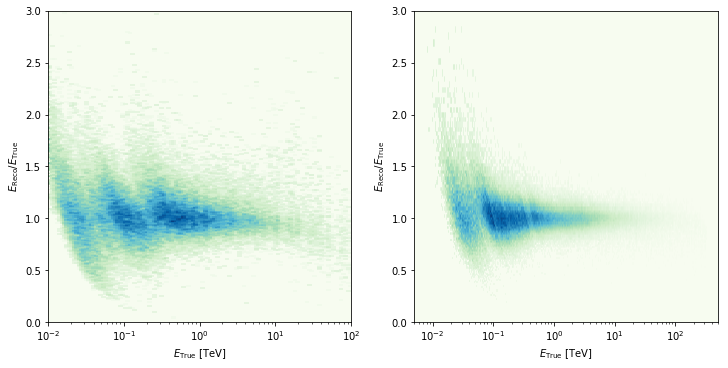

In [159]:
f, [ax1, ax2] = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))

filename = ('./../cta_irf.fits')
edisp = EnergyDispersion2D.read(filename, hdu="ENERGY DISPERSION")
edisp.plot_bias(ax=ax1)

filename = ('./../offical_irf_file.fits')
edisp_offical = EnergyDispersion2D.read(filename, hdu="ENERGY DISPERSION")
edisp_offical.plot_bias(ax=ax2)

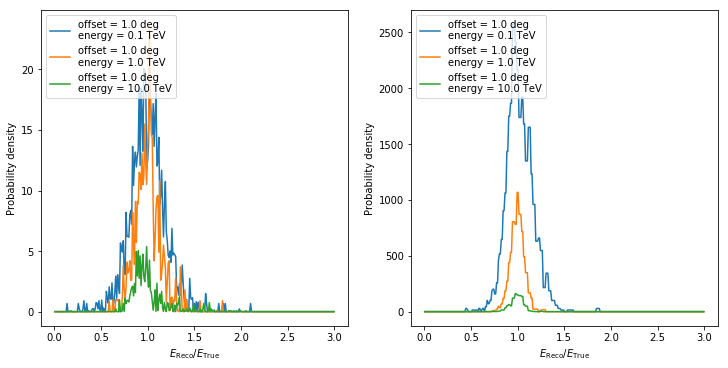

In [160]:
f, [ax1, ax2] = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))

filename = ('./../cta_irf.fits')
edisp = EnergyDispersion2D.read(filename, hdu="ENERGY DISPERSION")
edisp.plot_migration(ax=ax1)

filename = ('./../offical_irf_file.fits')
edisp_offical = EnergyDispersion2D.read(filename, hdu="ENERGY DISPERSION")
edisp_offical.plot_migration(ax=ax2)

(0.005, 200)

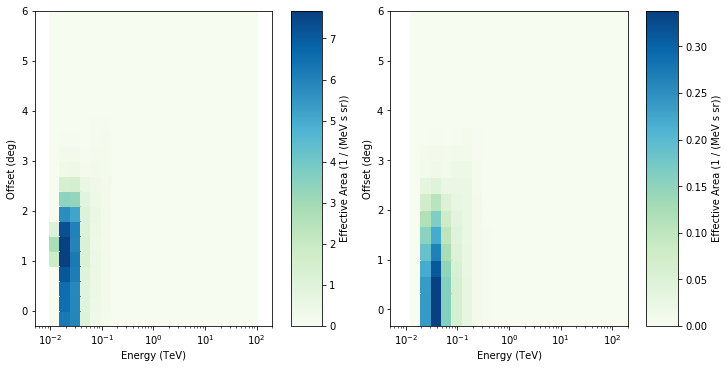

In [161]:
f, [ax1, ax2] = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))

filename = ('./../cta_irf.fits')
bkg2d = Background3D.read(filename, hdu="BACKGROUND").to_2d()
bkg2d.plot(ax=ax1)

filename = ('./../offical_irf_file.fits')
bkg2d_offical = Background3D.read(filename, hdu="BACKGROUND").to_2d()
bkg2d_offical.plot(ax=ax2)

ax2.set_xlim([0.005, 200])
ax1.set_xlim([0.005, 200])

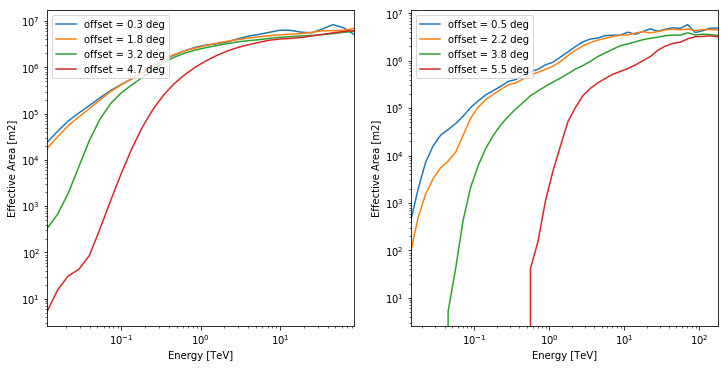

In [169]:
f, [ax1, ax2] = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))

filename = ('./../cta_irf.fits')
aeff = EffectiveAreaTable2D.read(filename, hdu="EFFECTIVE AREA")
aeff.plot_energy_dependence(ax=ax1)

filename = ('./../offical_irf_file.fits')
aeff_offical = EffectiveAreaTable2D.read(filename, hdu="EFFECTIVE AREA")
aeff_offical.plot_energy_dependence(ax=ax2)
# ax1.set_ylim([0, 8E6])
# ax2.set_ylim([0, 8E6])
ax1.set_yscale('log')
ax2.set_yscale('log')

(0, 0.7)

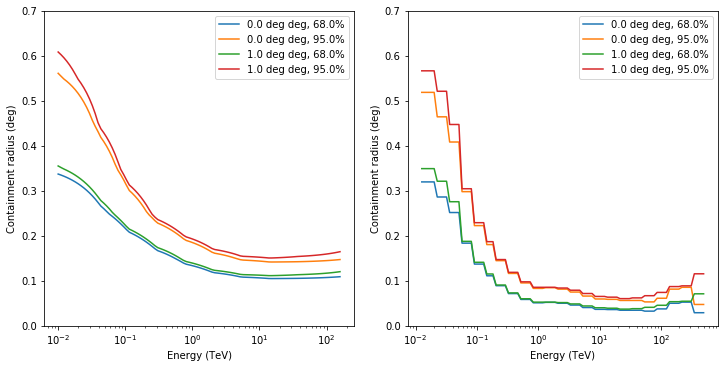

In [163]:
f, [ax1, ax2] = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))

filename = ('./../cta_irf.fits')
psf = PSF3D.read(filename, hdu="PSF")
psf.plot_containment_vs_energy(ax=ax1)
ax1.set_ylim([0, .7])

filename = ('./../offical_irf_file.fits')
psf_offical = EnergyDependentMultiGaussPSF.read(filename, hdu='POINT SPREAD FUNCTION')
psf_offical.plot_containment_vs_energy(ax=ax2)
ax2.set_ylim([0, .7])
# aeff_offical.plot_energy_dependence(ax=ax2)

(1e-14, 1e-10)

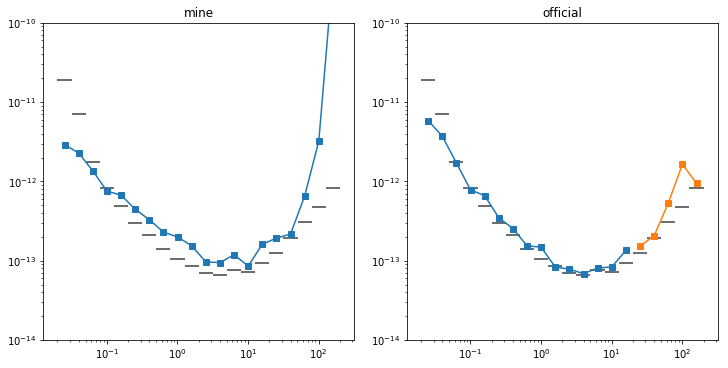

In [164]:
filename = ('./../cta_irf.fits')
sensitivity_table = sensitivity(filename, e_reco_bins=energy_reco, e_true_bins=energy_true)
filename = ('./../offical_irf_file.fits')
sensitivity_table_offical = sensitivity(filename, e_reco_bins=energy_reco, e_true_bins=energy_true)

f, [ax1, ax2] = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))
plot_sensi(sensitivity_table, ax1, title='mine')
plot_refrence(ax1)
plot_sensi(sensitivity_table_offical, ax2, title='official')
plot_refrence(ax2)
ax1.set_ylim([0.1E-13, 1e-10])
ax2.set_ylim([0.1E-13, 1e-10])

2896.6231242332424 1 / (MeV s sr)
85.5849380493164 1 / (MeV s sr)


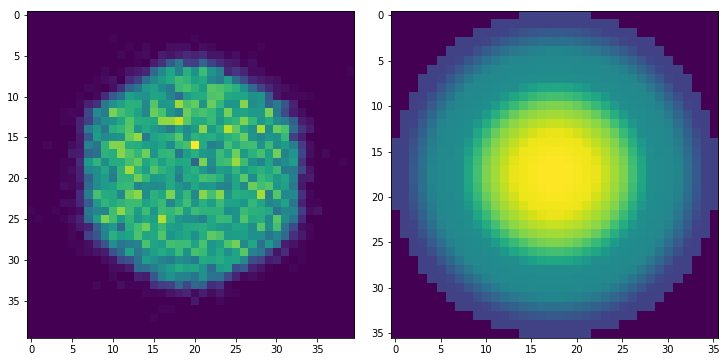

In [165]:
f, [ax1, ax2] = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))

filename = ('./../cta_irf.fits')
bkg3d = Background3D.read(filename, hdu="BACKGROUND")
ax1.imshow(bkg3d.data.data[5, :, :].value)
print(bkg3d.data.data.sum())
filename = ('./../offical_irf_file.fits')
bkg3d = Background3D.read(filename, hdu="BACKGROUND")
ax2.imshow(bkg3d.data.data[10, :, :].value)
print(bkg3d.data.data.sum())